## Prior sensitivity analysis

Objective to see how sensitive is the model to random walk prior specification. That is, we define the probability of a connect move as 

$$ P(connect) = \frac{e^{-\rho}}{1+e^{-\rho}}, \quad \rho \in (-\infty, \infty) $$

In this setup, the Metropolis--Hasting prior raito is 

$$ P(connect)/P(disconnect) = e^{-\rho} $$


In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.append('..')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.mh_parallel as pdg
import parallelDG.graph.junction_tree as jtlib
from networkx.drawing.nx_pydot import graphviz_layout
import itertools
import parallelDG.auxiliary_functions as auxlib

sns.set_style("whitegrid")
options = {
    "font_size": 12,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

    
def dedup_traj(traj): 
    print('length traj {}'.format(len(traj)))
    new_lst = []
    for i in traj:
        if not new_lst or new_lst[-1] != i:
            new_lst.append(i)
    return new_lst
    

## Testing Jump prior sensitivity

* alternate the jump proir threshold from 0 t 1

## Generate decomopsable table

In [2]:
graph_size = 7

In [3]:
tic = time.time()
all_edges = auxlib.edges_powerset(graph_size)
all_graphs_of_size_p = list(auxlib.powerset(all_edges))
decomp_table = auxlib.filter_decomposable_graphs(all_graphs_of_size_p, graph_size)
print("#.all graph {}, #decomp graphs {} of {} nodes".format(len(all_graphs_of_size_p), 
                                                              len(decomp_table), 
                                                              graph_size))
toc = time.time()
print('time took {:.2f}sec'.format(toc - tic))

KeyboardInterrupt: 

In [3]:
#auxlib.save_decomposable_table(decomp_table, '7_vertex_decomposable_graphs.csv')
decomp_table = pd.read_csv('7_vertex_decomposable_graphs.csv')

## Prior sensitivity analysis single move

In [6]:
def prior_sensitivity(rho = 0.1, single_move = True):
    print('rho {}'.format(rho))
    traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['jumppenalty', rho],
                                     graph_size  = graph_size, 
                                     single_move= single_move,
                                     cache = None)
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    def normalize(x):
        "plotting the probability density function"
        x = x.values
        a = float(np.sum(x))
        b = np.cumsum(x)
        return b/a
    result = {
        'rho': rho, 
        'single_move': single_move,
        'n_jt' : df['n_jt'].values,
        'count': normalize(df['count'].fillna(0)), 
        'count_t': normalize(df['count_t']),
        'count_jt': normalize(df['count_jt'])
    }
    return result

In [7]:
rho = [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
rho = [0.0, 0.2, 0.4, 0.6]
res = [prior_sensitivity(rho = r) for r in rho]

Metropolis-Hastings samples - single-move:   0%|          | 599/999999 [00:00<02:46, 5985.94it/s]

rho 0.0


Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [01:24<00:00, 11768.05it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11761.38updates/sec
Acceptance rate 0.7467
mcmc_subindex
length traj 1000000


Metropolis-Hastings samples - single-move:   0%|          | 959/999999 [00:00<01:44, 9589.14it/s]

rho 0.2


Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [01:30<00:00, 11071.68it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11066.34updates/sec
Acceptance rate 0.7864
mcmc_subindex
length traj 1000000


Metropolis-Hastings samples - single-move:   0%|          | 831/999999 [00:00<02:00, 8307.85it/s]

rho 0.4


Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [01:28<00:00, 11356.23it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11348.80updates/sec
Acceptance rate 0.7869
mcmc_subindex
length traj 1000000


Metropolis-Hastings samples - single-move:   0%|          | 875/999999 [00:00<01:54, 8744.67it/s]

rho 0.6


Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [01:13<00:00, 13660.56it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 13647.50updates/sec
Acceptance rate 0.7463
mcmc_subindex
length traj 1000000


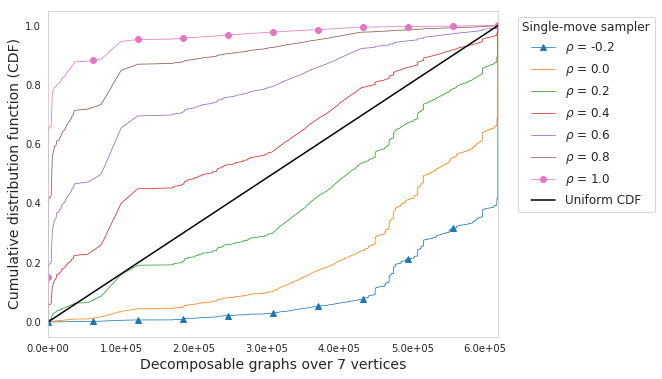

In [22]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))

for i, run in enumerate(res): 
    marker = None
    ct = run['count']
    color = plt.get_cmap('tab10')(i)
    if i == 0:
        marker = '^'
    if i == len(res) - 1: 
        marker = 'o'
    ax = pd.Series(ct).plot(linestyle= 'solid',
                            marker = marker,
                            markevery = len(ct) // 10,
                            linewidth = 0.75, 
                            color= color,
                            label= r'$\rho$ = {}'.format(run['rho']))

N = len(ct)
plt.plot([0, N], [0, 1], color='black', linewidth=1.5, label='Uniform CDF')
plt.grid(False)


ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)

# Place the legend outside the plot area on the right side
legend = plt.legend(title='Single-move sampler', 
                    fontsize='large', 
                    bbox_to_anchor=(1.03, 1), 
                    loc='upper left')

plt.setp(legend.get_title(), fontsize='large')

# Adjust the right margin to make room for the legend
plt.subplots_adjust(right=0.75)

#plt.savefig('prior_sensitivity_single_move.pdf', format='pdf')
plt.show()


### Parallel move

In [4]:
def prior_sensitivity(rho = 0.1, single_move = True):
    print('rho {}'.format(rho))
    traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['jumppenalty', rho],
                                     graph_size  = graph_size, 
                                     single_move= single_move,
                                     cache = None)
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    def normalize(x):
        "plotting the probability density function"
        x = x.values
        a = float(np.sum(x))
        b = np.cumsum(x)
        return b/a
    result = {
        'rho': rho, 
        'single_move': single_move,
        'n_jt' : df['n_jt'].values,
        'count_serial': normalize(df['count'].fillna(0)), 
        'count_t_serial': normalize(df['count_t']),
        'count_jt_serial': normalize(df['count_jt'])
    }
    traj.set_graph_trajectories()
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df['count'] = 0.0
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    result.update({
        'count': normalize(df['count'].fillna(0)), 
        'count_t': normalize(df['count_t']),
        'count_jt': normalize(df['count_jt'])
    }
    )
    return result

In [5]:
rho = [-0.6, -0.2, 0.0, 0.2, 0.4, 0.8]
res = [prior_sensitivity(rho = r, single_move=False) for r in rho]

Metropolis-Hastings - parallel moves:   0%|          | 1306/999999 [00:00<01:16, 13057.12it/s]

rho -0.6


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:13<00:00, 13605.32it/s]


Total of 2624399 updates, for an average of 2.62 per iteration or 35695.72updates/sec
Acceptance rate 0.7001
mcmc_subindex
length traj 2624399
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 1013/999999 [00:00<01:38, 10125.54it/s]

rho -0.2


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:18<00:00, 12730.29it/s]


Total of 2299619 updates, for an average of 2.30 per iteration or 29262.72updates/sec
Acceptance rate 0.8848
mcmc_subindex
length traj 2299619
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 751/999999 [00:00<02:33, 6512.71it/s]

rho 0.0


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:12<00:00, 13812.42it/s]


Total of 2102937 updates, for an average of 2.10 per iteration or 29015.15updates/sec
Acceptance rate 0.9832
mcmc_subindex
length traj 2102937
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 0/999999 [00:00<?, ?it/s]

rho 0.2


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:08<00:00, 14646.30it/s]


Total of 1906576 updates, for an average of 1.91 per iteration or 27891.07updates/sec
Acceptance rate 0.8873
mcmc_subindex
length traj 1906576
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 0/999999 [00:00<?, ?it/s]

rho 0.4


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:06<00:00, 15069.77it/s]


Total of 1730384 updates, for an average of 1.73 per iteration or 26033.75updates/sec
Acceptance rate 0.7941
mcmc_subindex
length traj 1730384
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 1316/999999 [00:00<01:15, 13159.60it/s]

rho 0.8


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [00:51<00:00, 19497.49it/s]


Total of 1437610 updates, for an average of 1.44 per iteration or 27983.16updates/sec
Acceptance rate 0.6203
mcmc_subindex
length traj 1437610
mcmc_index
length traj 1000000


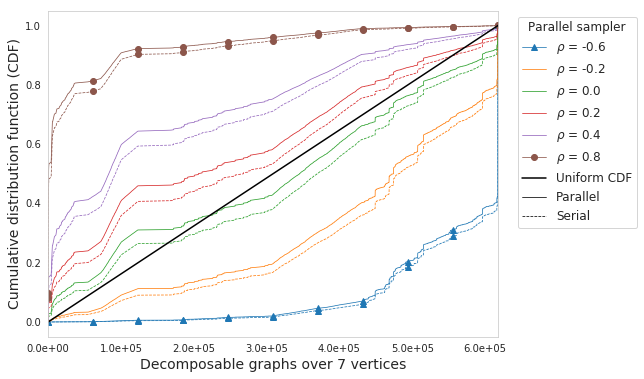

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))

for i, run in enumerate(res):
    marker = None
    if i == 0:
        marker = '^'
    if i == len(res) - 1: 
        marker = 'o'
    ct = run['count']
    ct_serial = run['count_serial']
    color = plt.get_cmap('tab10')(i)
    ax = pd.Series(ct).plot(linestyle='solid', 
                            linewidth = 0.75,
                            marker = marker,
                            markevery = len(ct) // 10,
                            color= color,
                            label= r'$\rho$ = {}'.format(run['rho']))
    ax = pd.Series(ct_serial).plot(linestyle='dashed',
                                   marker = marker,
                                   markevery = len(ct_serial) // 10,
                                   linewidth = 0.75, 
                                   color= color, label='')

N = len(ct)
plt.plot([0, N], [0, 1], color='black', linewidth=1.5, label='Uniform CDF')
plt.grid(False)



ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)


# Create custom lines
parallel_line = mlines.Line2D([], [], color='black', linewidth=0.75, label='Parallel')
serial_line = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=0.75, label='Serial')

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom lines to the handles and labels
handles.extend([parallel_line, serial_line])
labels.extend(['Parallel', 'Serial'])


# Place the legend outside the plot area on the right side
legend = plt.legend(handles, labels,
                    title='Parallel sampler', 
                    fontsize='large', 
                    bbox_to_anchor=(1.03, 1), 
                    loc='upper left')
plt.setp(legend.get_title(), fontsize='large')

# Adjust the right margin to make room for the legend
plt.subplots_adjust(right=0.75)

plt.savefig('prior_sensitivity_parallel.pdf', format='pdf')
plt.show()
